In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [9]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,GPN-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7


In [8]:
dataset_renaming = {
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
}

subset_renaming = {
    "all": "All",
    "missense_variant": "Coding",
    "non_coding": "Non-coding",
}

In [10]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    "all",
    "non_coding",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    "Enformer",
    "Borzoi",
    "GPN",
    "NucleotideTransformer",
    "HyenaDNA",
    "Caduceus",
]

def get_model_path(model, modality, dataset, subset):
    if modality == "Linear probing":
        predictor = f"{model}.LogisticRegression.chrom"
    elif modality == "Zero-shot":
        if model == "CADD":
            predictor = "CADD.plus.RawScore"
        elif model in ["Enformer", "Borzoi"]:
            predictor = f"{model}_L2_L2.plus.all"
        else:
            if "mendelian" in dataset:
                llr_version = "LLR"
                sign = "minus"
            elif "gwas" in dataset:
                llr_version = "absLLR"
                sign = "plus"
            predictor = f"{model}_{llr_version}.{sign}.score"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [11]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model_renaming.get(model, model),
                    df["score"],
                    df["se"]]
                )
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "AUPRC", "se"])
df

,dataset,subset,modality,model,AUPRC,se
0,Mendelian traits,All,Zero-shot,CADD,0.731996,0.027174
1,Mendelian traits,All,Zero-shot,GPN-MSA,0.754140,0.024227
2,Mendelian traits,All,Zero-shot,Enformer,0.216307,0.028863
3,Mendelian traits,All,Zero-shot,Borzoi,0.236692,0.035171
4,Mendelian traits,All,Zero-shot,GPN-Promoter,0.210777,0.028440
...,...,...,...,...,...,...
59,Complex traits,Non-coding,Linear probing,Borzoi,0.296654,0.014667
60,Complex traits,Non-coding,Linear probing,GPN-Promoter,0.190377,0.007060
61,Complex traits,Non-coding,Linear probing,NT,0.161823,0.005766
62,Complex traits,Non-coding,Linear probing,HyenaDNA,0.139070,0.007906


In [12]:
def plot_subset(subset):
    df_s = df.query("subset == @subset")
    if subset == "All":
        df_s = df_s[~df_s.model.isin(["Borzoi", "Enformer", "GPN-Promoter"])]

    g = sns.FacetGrid(
        df_s,
        col="dataset",
        row="modality",
        margin_titles=True,
        sharex="col",
        sharey=False,#"row",
        height=2.0,
        aspect=1.5,
    )

    def my_boxplot(data, **kwargs):
        data = data.sort_values("AUPRC", ascending=False)
        ax = plt.gca()
        g = sns.barplot(
            data=data,
            y="model",
            x="AUPRC",
            ax=ax,
            palette=palette,
            #showfliers=False, whis=0, # optional
        )
        ax.errorbar(
            x=data["AUPRC"],
            y=data["model"],
            xerr=data["se"],
            fmt='none',      # Do not add markers (those are already in the pointplot)
            color="black",
        )

    g.map_dataframe(my_boxplot)

    g.set(
        ylabel="",
        xlim=0.1,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    g.tight_layout()
    plt.savefig(f"../../results/plots/performance_{subset}.pdf", bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

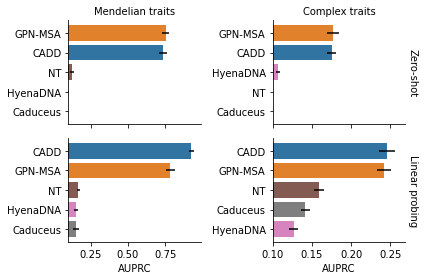

In [13]:
plot_subset("All")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

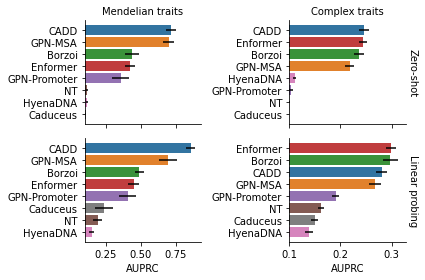

In [14]:
plot_subset("Non-coding")

In [4]:
dfs = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path)
                df["dataset"] = dataset_renaming.get(dataset, dataset)
                df["subset"] = subset_renaming.get(subset, subset)
                df["modality"] = modality
                df["model"] = model
                dfs.append(df)
df = pd.concat(dfs)
df

,chrom,n,Model,AUPRC,dataset,subset,modality,model
0,1,210,CADD.plus.RawScore,0.445951,Mendelian traits,Non-coding,Zero-shot,CADD
1,2,260,CADD.plus.RawScore,0.740507,Mendelian traits,Non-coding,Zero-shot,CADD
2,3,320,CADD.plus.RawScore,0.819572,Mendelian traits,Non-coding,Zero-shot,CADD
3,5,50,CADD.plus.RawScore,0.422789,Mendelian traits,Non-coding,Zero-shot,CADD
4,6,40,CADD.plus.RawScore,0.271075,Mendelian traits,Non-coding,Zero-shot,CADD
...,...,...,...,...,...,...,...,...
17,18,290,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.411377,Complex traits,Non-coding,Linear probing,Ensemble
18,19,610,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.342684,Complex traits,Non-coding,Linear probing,Ensemble
19,20,530,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.270244,Complex traits,Non-coding,Linear probing,Ensemble
20,21,140,Enformer+GPN-MSA+CADD.LogisticRegression.chrom,0.431087,Complex traits,Non-coding,Linear probing,Ensemble


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

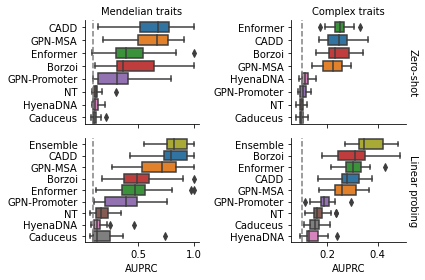

In [5]:
g = sns.FacetGrid(
    df,
    col="dataset",
    row="modality",
    margin_titles=True,
    sharex="col",
    sharey=False,#"row",
    height=2.0,
    aspect=1.5,
)

def my_boxplot(data, **kwargs):
    ax = plt.gca()
    sns.boxplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        order=data.groupby("model")["AUPRC"].median().sort_values(ascending=False).index,
        palette=palette,
        #showfliers=False, whis=0, # optional
    )
    ax.axvline(x=0.1, color="grey", linestyle="--")

g.map_dataframe(my_boxplot)

g.set(
    ylabel="",
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tight_layout()
#plt.savefig("../../results/plots/performance_non_coding.pdf", bbox_inches="tight")
#plt.savefig("../../results/plots/performance_all.pdf", bbox_inches="tight")

In [18]:
def format_score(x):
    return (x * 100).round().astype(int).apply(lambda y: f"{y:02d}")

def format_se(x):
    assert (x * 100).max() < 10
    return (x * 100).round().astype(int).apply(lambda y: f"{y:01d}")

df["value"] = format_score(df.AUPRC) + "$\pm$" + format_se(df.se)
#df["value"] = df.score.apply(lambda x: f"{x:.2f}") + "$\pm$" + df.se.apply(lambda x: f"{x:.2f}")

In [6]:
#df.loc[(df.model.isin(["Enformer", "Borzoi", "GPN"])) & (df.subset!="non_missense"), "value"] = "-"

In [14]:
bold_values = [
    ("mendelian_matched_9", "all", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "CADD"),
    ("mendelian_matched_9", "non_missense", "Zero-shot", "GPN-MSA"),

    ("mendelian_matched_9", "all", "Linear probing", "CADD"),
    ("mendelian_matched_9", "all", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "CADD"),
    ("mendelian_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "CADD"),
    ("mendelian_matched_9", "non_missense", "Linear probing", "Ensemble"),

    ("gwas_matched_9", "all", "Zero-shot", "CADD"),
    ("gwas_matched_9", "all", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "missense_variant", "Zero-shot", "CADD"),
    #("gwas_matched_9", "missense_variant", "Zero-shot", "GPN-MSA"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Enformer"),
    ("gwas_matched_9", "non_missense", "Zero-shot", "Borzoi"),

    ("gwas_matched_9", "all", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "missense_variant", "Linear probing", "Ensemble"),
    ("gwas_matched_9", "non_missense", "Linear probing", "Ensemble"),
]

for dataset, subset, modality, model in bold_values:
    mask = (
        (df.dataset==dataset) & (df.subset==subset) &
        (df.modality==modality) & (df.model==model)
    )
    df.loc[mask, "value"] = r"\textbf{" + df.loc[mask, "value"] + "}"

In [7]:
df.dataset = df.dataset.map({
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
})
df.subset = df.subset.map({
    "all": "All",
    "missense_variant": "Coding",
    "non_coding": "Non-coding",
})

df.dataset = df.dataset.map({
    "Mendelian traits": r"\textbf{Mendelian traits}",
    "Complex traits": r"\textbf{Complex traits}",
})
df.modality = df.modality.map({
    "Zero-shot": r"\textbf{Zero-shot}",
    "Linear probing": r"\textbf{Linear probing}",
})

In [19]:
df = df.pivot_table(
    index=["modality", "model"],
    columns=[
        "dataset",
        #"subset",
    ],
    values="value", aggfunc="first", sort=False,
)
df

dataset                     Mendelian traits Complex traits
modality       model                                       
Zero-shot      CADD                 70$\pm$3       25$\pm$1
               GPN-MSA              68$\pm$4       22$\pm$1
               Enformer             41$\pm$3       24$\pm$1
               Borzoi               42$\pm$5       24$\pm$1
               GPN-Promoter         34$\pm$5       10$\pm$0
               NT                   12$\pm$1       10$\pm$0
               HyenaDNA             12$\pm$1       11$\pm$0
               Caduceus             11$\pm$1       10$\pm$0
Linear probing CADD                 84$\pm$3       28$\pm$1
               GPN-MSA              66$\pm$5       27$\pm$1
               Enformer             45$\pm$4       30$\pm$1
               Borzoi               49$\pm$4       30$\pm$1
               GPN-Promoter         40$\pm$6       19$\pm$1
               NT                   18$\pm$2       16$\pm$1
               HyenaDNA             15$\pm$1       14$\pm$1
               Caduceus             19$\pm$5       15$\pm$1
               Ensemble             86$\pm$2       36$\pm$1

In [20]:
df.index.names = [None, None]
#df.columns.names = [None, None]
df.columns.name = None

In [21]:
print(df.to_latex(multicolumn_format='c', escape=False))

\begin{tabular}{llll}
\toprule
 &  & Mendelian traits & Complex traits \\
\midrule
\multirow[t]{8}{*}{Zero-shot} & CADD & 70$\pm$3 & 25$\pm$1 \\
 & GPN-MSA & 68$\pm$4 & 22$\pm$1 \\
 & Enformer & 41$\pm$3 & 24$\pm$1 \\
 & Borzoi & 42$\pm$5 & 24$\pm$1 \\
 & GPN-Promoter & 34$\pm$5 & 10$\pm$0 \\
 & NT & 12$\pm$1 & 10$\pm$0 \\
 & HyenaDNA & 12$\pm$1 & 11$\pm$0 \\
 & Caduceus & 11$\pm$1 & 10$\pm$0 \\
\cline{1-4}
\multirow[t]{9}{*}{Linear probing} & CADD & 84$\pm$3 & 28$\pm$1 \\
 & GPN-MSA & 66$\pm$5 & 27$\pm$1 \\
 & Enformer & 45$\pm$4 & 30$\pm$1 \\
 & Borzoi & 49$\pm$4 & 30$\pm$1 \\
 & GPN-Promoter & 40$\pm$6 & 19$\pm$1 \\
 & NT & 18$\pm$2 & 16$\pm$1 \\
 & HyenaDNA & 15$\pm$1 & 14$\pm$1 \\
 & Caduceus & 19$\pm$5 & 15$\pm$1 \\
 & Ensemble & 86$\pm$2 & 36$\pm$1 \\
\cline{1-4}
\bottomrule
\end{tabular}

